In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image


root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code
from model_src import gabor_feature_extractor
from utils import torch_utils, numpy_utility
from model_src import texture_utils

import pyrtools as pt
# this is a package described at https://pyrtools.readthedocs.io/en/latest/

In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


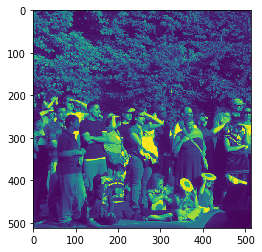

In [3]:
# Load a test image

image = Image.open('example-im-512x512.png')
image = np.reshape(image.getdata(),[512,512])

plt.figure();
plt.pcolormesh(image)
plt.axis('square')
plt.gca().invert_yaxis()

In [4]:
def quick_gaussian(npix):
    xvals, yvals = np.meshgrid(np.linspace(-1,1,npix), np.linspace(-1,1,npix));
    rvals = np.sqrt(xvals**2 + yvals**2);
    gauss = np.exp(-rvals/0.5);
    return gauss

In [9]:
# Create pyramid feature extractor (need to run cells at bottom of this notebook to create these functions)

n_ori=4;
n_sf=4;

prf_params = [0,0,0.5]

images = np.tile(np.expand_dims(np.expand_dims(image, axis=0), axis=0), [2,1,1,1])

feature_extractor = steerable_pyramid_extractor(pyr_height=n_sf, n_ori = n_ori)
# fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled = feature_extractor(image_batch, to_torch=False, device=device)

_fmaps_fn = feature_extractor

pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =  \
    get_higher_order_features(_fmaps_fn, images, prf_params, sample_batch_size=20, include_autocorrs=True, include_crosscorrs=True, \
                              autocorr_output_pix=7, autocorr_output_pix_lowpass = 5, n_prf_sd_out=2, aperture=1.0, device=device)


    

time elapsed: 1.76598 s
[0, 3]
64
[1, 2]
128
[2, 1]
256
[3, 0]
512


In [10]:
# Comparing some of the numerical values here, to the values generated in original matlab code.
# The scales go in opposite order here: in my pipeline they go low SF (small size image) to high SF (bigger images)
# In matlab code they go high to low. 
# Accounting for that here: if I put ff=3 here, then that corresponds to sc=1 in matlab code (for pyramid height=4)

npix_each_scale = [_fmaps_fn.pyr.pyr_size[(sc,0)][0] for sc in range(n_sf)]
npix_each_scale.append(_fmaps_fn.pyr.pyr_size['residual_lowpass'][0])
    
    
print('pixel features in original image')
names = ['mean', 'var', 'skew', 'kurt', 'min', 'max'];
for pp in range(6):
    print('  Weighted %s in original image: %.8f'%(names[pp],pixel_stats[0,pp]))

    
print('Mean of feature magnitudes in each band [nSF x nOri]\n')
print(torch.flipud(mean_magnitudes[0,:,:]))
    
ori1 = 0
ori2 = 1

# ff=0
# ff_reverse = n_sf-1 - ff
print('lowpass band, npix=%d'%npix_each_scale[n_sf])
print('   Weighted skew: %.8f'%marginal_stats_lowpass_recons[0,0,0])        
print('   Weighted kurtosis: %.8f'%marginal_stats_lowpass_recons[0,0,1])        

print('   Lowpass recon autocorrelation: %.8f'%lowpass_recon_autocorrs[0,0,0]) # low-freq residual is the first element here
print('   Real/spatially shifted lowpass within scale cross-correlation: %.8f'%real_spatshift_within_scale_crosscorrs[0,0,0,1])

for ff in range(4):
    

    ff_reverse = n_sf-1 - ff
#     print([ff, ff_reverse])
    print('sc=%d, npix=%d'%(ff,npix_each_scale[ff_reverse]))
    print('   Weighted skew: %.8f'%marginal_stats_lowpass_recons[0,ff+1,0])        
    print('   Weighted kurtosis: %.8f'%marginal_stats_lowpass_recons[0,ff+1,1]) # low-freq residual is the first element here


    print('   Magnitude autocorrelation: %.8f'%magnitude_feature_autocorrs[0,ff,0,0])
    print('   Lowpass recon autocorrelation: %.8f'%lowpass_recon_autocorrs[0,ff+1,0]) # low-freq residual is the first element here

    print('   Magnitude within scale cross-correlation: %.8f'%magnitude_within_scale_crosscorrs[0,ff,0])
    print('   Real within scale cross-correlation: %.8f'%real_within_scale_crosscorrs[0,ff,0,0])

    
    if ff>0:
        print('   Magnitude across scale cross-correlation: %.8f'%magnitude_across_scale_crosscorrs[0,ff,ori1, ori2])

        print('   Real/real across scale cross-correlation: %.8f'%real_imag_across_scale_crosscorrs[0,ff,0,ori1, ori2])
        print('   Real/imag across scale cross-correlation: %.8f'%real_imag_across_scale_crosscorrs[0,ff,1,ori1, ori2])
    else:
        print('   Real/spatially shifted lowpass across scale cross-correlation: %.8f'%real_spatshift_across_scale_crosscorrs[0,ff,ori1,1])
 
ff=3
ff_reverse = n_sf-1 - ff
print('highpass residual, npix=%d'%npix_each_scale[ff_reverse])      
print('   Highpass residual autocorrelation: %.8f'%highpass_resid_autocorrs[0,0,0])
print('   Highpass residual variance: %.8f'%variance_highpass_resid[0,0])

pixel features in original image
  Weighted mean in original image: 65.84614563
  Weighted var in original image: 3715.29394531
  Weighted skew in original image: 1.33787656
  Weighted kurt in original image: 4.08186150
  Weighted min in original image: 0.00000000
  Weighted max in original image: 255.00000000
Mean of feature magnitudes in each band [nSF x nOri]

tensor([[   7.9991,    6.9673,    7.9418,    8.5642],
        [  41.6647,   35.7855,   42.0171,   43.7019],
        [ 208.3934,  179.8007,  222.2725,  226.4421],
        [1022.3289,  859.8892,  902.1808,  947.4236]], device='cuda:0')
lowpass band, npix=32
   Weighted skew: 1.34952652
   Weighted kurtosis: 5.85247707
   Lowpass recon autocorrelation: 9842906.00000000
   Real/spatially shifted lowpass within scale cross-correlation: 1539.60034180
sc=0, npix=64
   Weighted skew: 1.26171899
   Weighted kurtosis: 4.64101791
   Magnitude autocorrelation: 11497.49609375
   Lowpass recon autocorrelation: 720955.87500000
   Magnitude w

In [6]:
import torch.nn as nn

class steerable_pyramid_extractor(nn.Module):
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height # how many spatial frequencies?
        self.pyr = None
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(image_batch[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)
            self.pyr = pyr # storing the most recently generated pyramid, in case we need its properties later
            
            if ii==0:  
                
                # Initialize all the feature maps we want to store...
                fmaps_complex = []
                fmaps_coarser_upsampled = []
               
                # Will generate several low-pass filtered representations of the image - will use these as additional feature maps for 
                # computing autocorrelations and marginal statistics.
                fmaps_lowpass_recon = []
                fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
               
                # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
                sf_reverse  = self.pyr_height  # need to go backward because pyr comes out in the opposite order from what i want
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))
                    
                    # Initialize "parent" representations for this level (map from the next coarsest resolution, upsampled to the finer scale)
                    # To be used for cross-scale comparisons.
                    if sf==0:
                        # this will be the lowpass residual (non-oriented).
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, 1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))                     
                    else:
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))     
                        
                    fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                         pyr.pyr_coeffs[sf_reverse,0].shape[1])))

                fmaps_resid = []    
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))

            # First get lowpass filtered representation of the image
            lowpass_recon = pyr.recon_pyr(levels='residual_lowpass', bands='all', twidth=1) 
            scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size['residual_lowpass'][0]
            lowpass_recon = texture_utils.shrink(lowpass_recon, scale_by)*scale_by**2
            fmaps_lowpass_recon[0][ii,0,:,:] = lowpass_recon
            
            # Get the "parent" for lowest SF level (upsample the residual lowpass)
            upsampled = texture_utils.expand(pyr.pyr_coeffs['residual_lowpass'], factor=2)/2**2
            fmaps_coarser_upsampled[0][ii,0,:,:] = upsampled
            
            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height # need to go backward because pyr comes out in the opposite order from what i want
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     

                    # These are the main feature maps of the pyramid - one feature map per scale per orientation band.
                    # Complex number, can take the magnitude or real/imaginary part to simulate complex or simple cell-type responses.
                    fmaps_complex[sf][ii,oo,:,:] = pyr.pyr_coeffs[(sf_reverse,oo)]
                    
                    if sf<self.pyr_height-1:
                        # Store this as a "parent" representation, will be used for the next most fine SF level (i.e. sf+1)
                        upsampled = texture_utils.expand(pyr.pyr_coeffs[(sf_reverse,oo)], factor=2)/2**2
                        # Double the phase (angle of the complex number); note this doesn't affect the magnitude. 
                        phase_doubled = double_phase(upsampled)
                        fmaps_coarser_upsampled[sf+1][ii,oo,:,:] = phase_doubled
                   
                        
                # Get the bandpass filtered representation for this scale
                bandpass_image = np.real(pyr.recon_pyr(levels=sf_reverse, bands='all', twidth=1))
                scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size[(sf_reverse,0)][0]
                bandpass_image = texture_utils.shrink(bandpass_image, factor=scale_by)*scale_by**2
                
                # Add it onto the lowpass_recon (gets modified every loop iteration)
                lowpass_recon = texture_utils.expand(lowpass_recon, factor=2)/2**2
                lowpass_recon = lowpass_recon + bandpass_image
                fmaps_lowpass_recon[sf+1][ii,0,:,:] = lowpass_recon
            

            # Grab residual feature maps, the lowest and highest levels of the pyramid
            fmaps_resid[0][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_resid[1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
            
            
        elapsed = time.time() - t
        print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_complex = [torch.from_numpy(fm).to(device) for fm in fmaps_complex]            
            fmaps_resid = [torch_utils._to_torch(fm, device=device) for fm in fmaps_resid]
            fmaps_lowpass_recon = [torch_utils._to_torch(fm, device=device) for fm in fmaps_lowpass_recon]                      
            fmaps_coarser_upsampled = [torch.from_numpy(fm).to(device) for fm in fmaps_coarser_upsampled]

        return fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled
    
   
        

In [7]:
def double_phase(fmap):
    
    """
    Double the phase (i.e. angle) values of a complex array
    modified from https://github.com/LabForComputationalVision/textureSynth
    """     
    
    rtmp = np.real(fmap)
    itmp = np.imag(fmap)

    theta = np.arctan2(rtmp, itmp) # this is exactly how it is written in matlab code, but might not be correct. need to leave this to get matching number.
#     theta = np.arctan2(itmp, rtmp) # first get original phase (angle)
    rad = np.sqrt(rtmp**2 + itmp**2) # then get original magnitude

    # then put back together, using a*e^(ib)
    fmap_phase_doubled = rad * np.exp(2 * 1j*theta) 

    return fmap_phase_doubled


def get_higher_order_features(_fmaps_fn, images, prf_params, sample_batch_size=20, include_autocorrs=True, include_crosscorrs=True, autocorr_output_pix=7, autocorr_output_pix_lowpass = 5, n_prf_sd_out=2, aperture=1.0, device=None):

    """
    Compute all higher-order features (cross-spatial and cross-feature correlations) for a batch of images.
    Input the module that defines steerable pyramid, and prf parameters.
    Returns arrays of each higher order feature.    
    """

    n_trials = np.shape(images)[0]
    x,y,sigma = prf_params
    
    # hard coded to match some values in matlab code
    my_bboxes = [[241,304,225,288],[120,151,112,143],[60,75,56,71],[30,45,28,43],[15,22,14,21]]

    assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

    n_sf = _fmaps_fn.pyr_height
    n_ori = _fmaps_fn.n_ori
    
    
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    # mean, variance, skew, kurtosis, min, max
    pixel_stats = torch.zeros((n_trials,6), device=device)

    # Mean magnitude each scale/orientation, within the prf.
    mean_magnitudes = torch.zeros((n_trials, n_sf, n_ori), device=device)
    mean_realparts = torch.zeros((n_trials, n_sf, n_ori), device=device)

    # Store the skew and kurtosis of the lowpass reconstructions at each scale
    marginal_stats_lowpass_recons = torch.zeros((n_trials, n_sf+1, 2), device=device)

    # Variance of the highpass residual
    variance_highpass_resid = torch.zeros((n_trials, 1), device=device)

    # how many unique autocorrelation values will we get out for each feature map
    n_autocorr_vals = int((autocorr_output_pix**2+1)/2)
    n_autocorr_vals_lowpass = int((autocorr_output_pix_lowpass**2+1)/2)

    # Spatial autocorrelation of the magnitude of spectral coefficients, within each scale and orientation.
    magnitude_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, n_autocorr_vals], device=device) # this is ace in the matlab code

    # Spatial autocorrelation of the partially-reconstructed lowpass image representation at each scale
    lowpass_recon_autocorrs = torch.zeros([n_trials, n_sf+1, n_autocorr_vals], device=device) # this is acr in the matlab code

    # Spatial autocorrelation of the highpass residual
    highpass_resid_autocorrs = torch.zeros([n_trials, 1, n_autocorr_vals], device=device)

    # Within scale correlations of feature maps: compare feature map magnitudes for different orientations.
    magnitude_within_scale_crosscorrs = torch.zeros([n_trials, n_sf+1, n_ori_pairs], device=device) # this is C0 in the matlab code
    # Using the real parts.
    real_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, 1, n_ori_pairs], device=device) # this is Cr0 in the matlab code

    # Cross-scale correlations of feature maps: always comparing each scale to an up-sampled version of the scale coarser than it.
    magnitude_across_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori, n_ori], device=device) # this is Cx0 in the matlab code

    # Cross-scale correlations, using the real and imaginary parts separately. The phase (angle) of the coarser map is doubled before computing these.
    real_imag_across_scale_crosscorrs = torch.zeros([n_trials, n_sf, 2, n_ori, n_ori], device=device) # this is Crx0 in the matlab code

    # These are comparisons withspatially shifted versions of the lowpass residual. Not sure we need this...
    n_spatshifts = 5;
    real_spatshift_within_scale_crosscorrs = torch.zeros([n_trials, 1, n_spatshifts, n_spatshifts], device=device)# this is Cr0 in the matlab code
    real_spatshift_across_scale_crosscorrs = torch.zeros([n_trials, 1, n_ori, n_spatshifts], device=device)  # this is Crx0 in the matlab code

    
    bb=-1
    for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1

        fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled = _fmaps_fn(images[batch_inds], to_torch=True, device=device)

        if bb==0:
            npix_each_scale = [_fmaps_fn.pyr.pyr_size[(sc,0)][0] for sc in range(n_sf)]
            npix_each_scale.append(_fmaps_fn.pyr.pyr_size['residual_lowpass'][0])

        # First working with the finest scale (original image)
        ff_reverse = 0
        n_pix = npix_each_scale[ff_reverse]
        spatial_weights = quick_gaussian(n_pix) # Hard coded to match some values in matlab script
        ind = my_bboxes[ff_reverse]
        ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
        patch_bbox_square = ind
        #     g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        #     spatial_weights = g[2][0]

        #     patch_bbox_rect = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=False)
            # for autocorrelation, forcing the input region to be square
        #     patch_bbox_square = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True)


        # Gather pixel-wise statistics here 
        wmean, wvar, wskew, wkurt = texture_utils.get_weighted_pixel_features(images[batch_inds], spatial_weights, device=device)
        pixel_stats[batch_inds,0] = torch.squeeze(wmean)
        pixel_stats[batch_inds,1] = torch.squeeze(wvar)
        pixel_stats[batch_inds,2] = torch.squeeze(wskew)
        pixel_stats[batch_inds,3] = torch.squeeze(wkurt)
        pixel_stats[batch_inds,4] = torch_utils._to_torch(np.squeeze(np.min(np.min(images[batch_inds], axis=3), axis=2)), device=device)
        pixel_stats[batch_inds,5] = torch_utils._to_torch(np.squeeze(np.max(np.max(images[batch_inds], axis=3), axis=2)), device=device)

        # Autocorrs of the highpass residual
        highpass_resid = fmaps_resid[1]
        auto_corr = texture_utils.weighted_auto_corr_2d(highpass_resid, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)       
        highpass_resid_autocorrs[batch_inds,0,:] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals])

        # variance of the highpass residual
        m, wvar, s, k = texture_utils.get_weighted_pixel_features(highpass_resid, spatial_weights, device=device)
        variance_highpass_resid[batch_inds,0] = torch.squeeze(wvar)

        # Next work with the low-pass reconstruction
        ff_reverse = n_sf
        n_pix = npix_each_scale[ff_reverse]
        spatial_weights = quick_gaussian(n_pix)
        ind = my_bboxes[ff_reverse]
        ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
        patch_bbox_square = ind
        #     g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        #     spatial_weights = g[2][0]

        #     patch_bbox_rect = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=False)
            # for autocorrelation, forcing the input region to be square
        #     patch_bbox_square = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True)

        lowpass_rec = fmaps_lowpass_recon[0]

        # Marginal stats of low-pass reconstruction
        m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_rec, spatial_weights, device=device)
        marginal_stats_lowpass_recons[batch_inds,0,0] = torch.squeeze(wskew)
        marginal_stats_lowpass_recons[batch_inds,0,1] = torch.squeeze(wkurt)

        # Autocorrs of low-pass reconstruction 
        auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_rec, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix_lowpass, subtract_patch_mean = True, enforce_size=True, device=device)       
        lowpass_recon_autocorrs[batch_inds,0,0:n_autocorr_vals_lowpass] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals_lowpass])

        # Looping over frequency (scales) 
        # Loop goes low SF to higher SF
        for ff in range(n_sf):
            ff_reverse = n_sf-1 - ff
            print([ff, ff_reverse])
            # Scale specific things - get the prf at this resolution of interest    
            n_pix = npix_each_scale[ff_reverse]
            print(n_pix)
            spatial_weights = quick_gaussian(n_pix)
            ind = my_bboxes[ff_reverse]
            ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
            patch_bbox_square = ind
        #     g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        #     spatial_weights = g[2][0]

        #     patch_bbox_rect = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=False)
            # for autocorrelation, forcing the input region to be square
        #     patch_bbox_square = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True)

            lowpass_summed = fmaps_lowpass_recon[ff+1]
            m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_summed, spatial_weights, device=device)
            marginal_stats_lowpass_recons[batch_inds,ff+1,0] = torch.squeeze(wskew)
            marginal_stats_lowpass_recons[batch_inds,ff+1,1] = torch.squeeze(wkurt)

            # Autocorrs of low-pass reconstruction (at this scale)

            auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_summed, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)       
            lowpass_recon_autocorrs[batch_inds,ff+1,:] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals])


            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       

                # Complex cell responses
                mag1 = torch.abs(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                wmean, v, s, k = texture_utils.get_weighted_pixel_features(mag1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_magnitudes[batch_inds, ff, oo1] = torch.squeeze(wmean)

                mag1 = mag1 - torch.tile(torch.mean(torch.mean(mag1, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                real1 = torch.real(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()      

                wmean, v, s, k = texture_utils.get_weighted_pixel_features(real1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_realparts[batch_inds, ff, oo1] = torch.squeeze(wmean)

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)     
                auto_corr = texture_utils.weighted_auto_corr_2d(mag1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)       
                magnitude_feature_autocorrs[batch_inds,ff,oo1,:] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals])

                # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    mag2 = torch.abs(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()      
                    mag2 = mag2 - torch.tile(torch.mean(torch.mean(mag2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                    # Complex cell within-scale cross correlations
                    cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)

                    magnitude_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                    real2 = torch.real(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()                     

                    # Simple cell within-scale cross correlations
                    cross_corr = texture_utils.weighted_cross_corr_2d(real1, real2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    real_within_scale_crosscorrs[batch_inds,ff,0,xx] = torch.squeeze(cross_corr);

                    # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
                    if ff>0:

                        for oo2 in range(n_ori):

                            # Complex cell response for neighboring (coarser) scale                        
                            mag_coarser2 = torch.abs(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                            mag_coarser2 = mag_coarser2 - torch.tile(torch.mean(torch.mean(mag_coarser2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                            # Complex cell across-scale cross correlations
                            cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)            
                            magnitude_across_scale_crosscorrs[batch_inds,ff,oo1,oo2] = torch.squeeze(cross_corr)

                            real_coarser2 = torch.real(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                            imag_coarser2 = torch.imag(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                            cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_imag_across_scale_crosscorrs[batch_inds,ff,0,oo1,oo2] = torch.squeeze(cross_corr)

                            cross_corr = texture_utils.weighted_cross_corr_2d(real1, imag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_imag_across_scale_crosscorrs[batch_inds,ff,1,oo1,oo2] = torch.squeeze(cross_corr)

                    else:

                        # instead of different orientations for the parent reps here, have spatially shifted versions.
                        real_coarser = torch.real(fmaps_coarser_upsampled[ff][:,0,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                        shifts = [[0,0],[1,3],[-1,3],[1,2],[-1,2]]
                        for si1, shift1 in enumerate(shifts):

                            ss,dd = shift1
                            real_coarser_shifted1 = torch.roll(real_coarser, shifts=ss, dims=dd)               
                            cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser_shifted1, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_spatshift_across_scale_crosscorrs[batch_inds,ff,oo1,si1] = torch.squeeze(cross_corr)

                            for si2, shift2 in enumerate(shifts):

                                ss,dd = shift2
                                real_coarser_shifted2 = torch.roll(real_coarser, shifts=ss, dims=dd)               
                                cross_corr = texture_utils.weighted_cross_corr_2d(real_coarser_shifted1, real_coarser_shifted2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                                real_spatshift_within_scale_crosscorrs[batch_inds,ff,si1,si2] = torch.squeeze(cross_corr)

                                
        
    return pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs


    